In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

# load general packages
import numpy as np
import matplotlib.pyplot as plt

# load modules related to this exercise
from model_zucher import zurcher
from Solve_NFXP import solve_NFXP
import estimate_NFXP as estimate

#### Before solving the exercise, you should download line_profiler. Line_profiler is a tool to check the performance of our code. To install line_profiler, you can open anaconda prompt and write "pip install line-profiler" (without the " " of course). If you want to know more about line_profiler, check the link below:

https://github.com/rkern/line_profiler.

# Exercise 1

#### Consider the engine replacement model given by:

$$
V(x,\varepsilon) = \max_{d\in \{0,1\}} \big\{ u(x,d) + \varepsilon_d + \beta
\underbrace{\int_{X} \int_{\Omega} V(x',\varepsilon') \pi(x'|x,d) q(\varepsilon'|x') dx' d\varepsilon' }_{EV(x,d)} \big\}
$$

Where $ \varepsilon $ is extreme value Type I distribued and utility is given by:

$$
u(x,d)=\left \{
\begin{array}{ll}
    -RC-c(0,\theta_1) & \text{if }d=\text{replace}=1 \\
    -c(x,\theta_1) & \text{if }d=\text{keep}=0
\end{array} \right.
$$

Here

- $ RC $ = replacement cost  
- $ c(x,\theta_1) $ = cost of maintenance with preference parameters $ \theta_1 $  




#### 1. Look at ReadMe.txt to get an overview of the code

#### 2. Invistigate how the code works, that is ensure you understand:
<il type ="a">
<li> zurcher.init</li>
<li> zurcher.setup</li>
<li> zurcher.create_grid</li>
<li> zucher.state_transition </li>
<li> zucher.bellman </li>

You can see how they are called below
    

#### 3. Run the code below and make sure you understand what we are printing. 
What does the last transition probability in each row (equal to 0.05) come from?
- This comes from the fact that $p$ must sum to one and since 0.65+0.2+0.1=0.95. Therefore, we are lacking 0.05

In [2]:
do_settings = {
    'RC': 0.5,
    'n': 12,
    'p':[0.65,0.2,0.1]   
}
model = zurcher(**do_settings)

print('Model grid:\n',model.grid)
print('Transition probabilities conditional on not replacing:\n',model.P1)
print('Transition probabilities conditional on replacing:\n',model.P2)
ev,pk, dev = model.bellman(np.zeros((model.n)),output=3)
print('Bellman one run:\n',ev)

Model grid:
 [ 0  1  2  3  4  5  6  7  8  9 10 11]
Transition probabilities conditional on not replacing:
 [[0.65 0.2  0.1  0.05 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.65 0.2  0.1  0.05 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.65 0.2  0.1  0.05 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.65 0.2  0.1  0.05 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.65 0.2  0.1  0.05 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.65 0.2  0.1  0.05 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.65 0.2  0.1  0.05 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.65 0.2  0.1  0.05 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.65 0.2  0.1  0.05]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.65 0.2  0.15]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.65 0.35]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]
Transition probabilities conditional on replacing:
 [[0.65 0.2  0.1  0.05 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.65 0.2  0.1  0.05

### Newton's Method

Next, we need to solve the model. Rust 1987 uses Newton–Kantorovich (NK) theorem to solve the Bellman equation in the engine replacement model. To understand the NK algorithm, consider using the Newton's method to solve the single-variable equation, $f(x)=0$. The Newton method uses the iterative procedure stated below to solve the equation:

$$x_{n+1} = x_{n} - \frac{f(x_n)}{f'(x_n)}$$

### 4. Use the Newton's Method to solve the equation below. Fill in the Newton step. Try to vary the starting value and see if the solution changes.


$$f(x) = 3x^2 - exp(x)=0$$

$$f'(x) = g(x) = 6x-exp(x) $$

Root of f(x): 3.73
Number of iterations to archieve convergence: 6


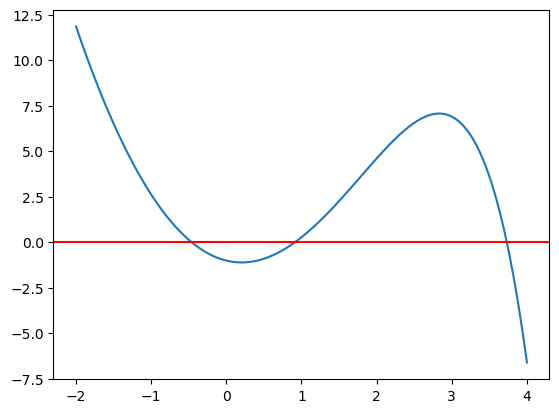

In [3]:
f = lambda x: 3*x**2-np.exp(x)
g = lambda x: 6*x-np.exp(x)

def newton(f, g, x0, tol=10e-5, max_iter=100):
    delta = 2000
    it=0
    while (max_iter>= it and tol<delta):
        x1 = x0- f(x0)/g(x0)
        delta = abs(x1-x0)
        it += 1
        x0 = x1
    return x1, it


x0,it = newton(f = f, g = g, x0 = 5)

x = np.linspace(-2, 4, num=100)
fx = f(x)
plt.plot(x, fx)
plt.axhline(y=0, color='r', linestyle='-')

print('Root of f(x):', round(x0,2))
print('Number of iterations to archieve convergence:', it)

### Newton-Kantorovich

Now consider solving the engine replacement model. To do so, we need to find the expected value function that solves the Bellman equation.

$$
EV(x,d) =  \Gamma(EV)(x,d) \quad\Leftrightarrow\quad (I - \Gamma)(EV)(x,d)=\mathbb{0}
$$

Similar to the Newton iteration, the **NK iteration** uses the following equation

$$
EV_{k+1} = EV_{k} - (I-\Gamma')^{-1} (I-\Gamma)(EV_k)
$$

- The new operator is the difference between the identity operator \$I\$ and Bellman operator $ \Gamma  $  
- $ \mathbb{0} $ is zero function  
- $ I-\Gamma' $ is a Fréchet derivative of the operator $ I-\Gamma $  

### 5. Solve the model. In order to solve the model, you should understand:
<li> solve_NFXP.init</li>
<li> solve_NFXP.setup</li>
<li> solve_NFXP.poly </li>
<li> solve_NFXP.sa </li>
<li> solve_NFXP.nk </li>
</il>
You can see how they are called below: 

In [4]:
algorithm = 'poly'
do_settings_solver = {
    'sa_min': 10,
    'sa_max': 1000000,  
    'printfxp': 2
}

solver = solve_NFXP(**do_settings_solver)
model = zurcher()

ev0 = np.zeros((model.n)) # Initial guess
if algorithm == 'sa':
    ev = solver.sa(model.bellman, ev0)
elif algorithm == 'poly':
    ev = solver.poly(model.bellman, ev0, beta = model.beta)
else:
    print('Algorithm must be "sa" or "poly"')


Begin contraction iterations (for the 1 time)
Iteration 1, tol     0.4273, tol(j)/tol(j-1)        nan
Iteration 2, tol     0.4272, tol(j)/tol(j-1)        nan
Iteration 3, tol     0.4272, tol(j)/tol(j-1)        nan
Iteration 4, tol     0.4271, tol(j)/tol(j-1)        nan
Iteration 5, tol     0.4271, tol(j)/tol(j-1)        nan
Iteration 6, tol      0.427, tol(j)/tol(j-1)        nan
Iteration 7, tol     0.4269, tol(j)/tol(j-1)        nan
Iteration 8, tol     0.4268, tol(j)/tol(j-1)        nan
Iteration 9, tol     0.4266, tol(j)/tol(j-1)        nan
Iteration 10, tol     0.4264, tol(j)/tol(j-1)        nan
Iteration 11, tol     0.4262, tol(j)/tol(j-1)     0.9994
SA stopped prematurely due to relative tolerance. Start NK iterations
Elapsed time 0.0256 seconds
Begin Newton-Kantorovich iterations (for the 1 time)
Iteration 1, tol      13.17, tol(j)/tol(j-1)          1
Iteration 2, tol      0.308, tol(j)/tol(j-1)    0.02339
Iteration 3, tol    0.08956, tol(j)/tol(j-1)     0.2907
Iteration 4, tol 

#### 6. Now we have to estimate the model. In order to estimate the model, you should understand:
<il type ="a">
<li> zurcher.read_busdata </li>
<li> estimate_NFXP.estimate  </li>
<li> estimate_NFXP.ll  </li>
</il>

You can see how they are called below:

#### 7. Estimate the model

In [6]:
# Set up the model
model = zurcher()

# Set-up solver
solver = solve_NFXP()

# Read the data
data = model.read_busdata(bustypes=[1,2,3,4])
samplesize = data.shape[0]

# Estimate the model
import time
t0 = time.time()
theta0 = [0,0]

# args for nfxp estimate
nfxp_model, optim_res, pnames, theta_hat, Avar, converged=estimate.estimate(model, solver,data,theta0=theta0, twostep=0)

t1 = time.time()
time = t1-t0

# Print the result
print(f'Structual estimation using busdata from Rust(1987)')
print(f'Beta        = {model.beta:.4f}')
print(f'n           = {model.n}')
print(f'Sample size = {samplesize}\n \n')

print(f'Parameters     Estimates    s.e. ') 
print(f'{pnames[0]}             {theta_hat[0]:.4f}     {np.sqrt(Avar[0,0]):.4f} ')
print(f'{pnames[1]}              {theta_hat[1]:.4f}     {np.sqrt(Avar[1,1]):.4f} \n ')
print(f'{pnames[2]}(1)           {theta_hat[2]:.4f}     {np.sqrt(Avar[2,2]):.4f}  ')
print(f'{pnames[2]}(2)           {theta_hat[3]:.4f}     {np.sqrt(Avar[3,3]):.4f}  ')
print(f'{pnames[2]}(3)           {theta_hat[4]:.4f}     {np.sqrt(Avar[4,4]):.4f}  ')
print(f'{pnames[2]}(4)           {theta_hat[5]:.4f}     {np.sqrt(Avar[5,5]):.4f}  \n')


print(f'Log-likelihood {-optim_res.fun*samplesize:.2f}') 
print(f'runtime (seconds) {time:.4f}')
print(f'The model converged: {converged}')

Structual estimation using busdata from Rust(1987)
Beta        = 0.9999
n           = 175
Sample size = 8156
 

Parameters     Estimates    s.e. 
RC             9.7689     1.2264 
c              1.3427     0.3153 
 
p(1)           0.1069     0.0035  
p(2)           0.5154     0.0059  
p(3)           0.3621     0.0055  
p(4)           0.0143     0.0013  

Log-likelihood -8599.86
runtime (seconds) 2.0332
The model converged: True


In [10]:
print(data)

        d    x  dx1
1     0.0    2    1
2     0.0    3    1
3     0.0    5    2
4     0.0    7    2
5     0.0    9    2
...   ...  ...  ...
8255  0.0  133    0
8256  0.0  134    1
8257  0.0  135    1
8258  0.0  136    1
8259  0.0  136    0

[8156 rows x 3 columns]


#### 8. Try using line_profiler in python. This gives you a lot of information about the performance of your code

In [7]:
%lprun -f estimate.ll  -f estimate.estimate estimate.estimate(model, solver,data,theta0=theta0, twostep=0)

Timer unit: 1e-09 s

Total time: 10.3472 s
File: /Users/jvander/Documents/Dynamic-Programming/Exercises/Discrete/estimate_NFXP.py
Function: estimate at line 9

Line #      Hits         Time  Per Hit   % Time  Line Contents
     9                                           def estimate(model,solver,data,theta0=[0,0],twostep=0):
    10                                               """" Estimate model using NFXP"""
    11                                               global ev
    12         1    2615000.0    3e+06      0.0      ev = np.zeros((model.n)) 
    13                                               
    14         1    1005000.0    1e+06      0.0      samplesize = data.shape[0]
    15                                               
    16                                               # STEP 1: Find p non-parametrically
    17         1   14702000.0    1e+07      0.1      tabulate = data.dx1.value_counts() # Count number of observations for each dx1
    18         5    2055000.0 4110

In [8]:
ev0 = np.zeros((model.n)) # Initial guess
%lprun -f solve_NFXP.nk -f solve_NFXP.poly solve_NFXP.poly(solver,model.bellman, ev0, beta = model.beta)

Timer unit: 1e-09 s

Total time: 0.140679 s
File: /Users/jvander/Documents/Dynamic-Programming/Exercises/Discrete/Solve_NFXP.py
Function: poly at line 31

Line #      Hits         Time  Per Hit   % Time  Line Contents
    31                                               def poly(self,bellman, V0=np.zeros(1), beta= 0.0, output=1):
    32                                                   """" Solves the model using the poly-algorithm.
    33                                                   set beta = 0.0 if you want to solve only with successive approximations.
    34                                                   """
    35                                           
    36         1       2000.0   2000.0      0.0          t0poly = time.time()  # set the starting time
    37                                           
    38                                                   # Loop over the maximum number of switches between contraction iterations and Newton-Kantorovich iterations
    

#### 9. In the code, we are using analytical hessian and gradient. Let us now try to use numerical equivalents. 


a) Now try changing the optimizer options, and turn the use of the non-numerical Hessian off . What happens?

b) Now also try it with the analytical gradient off, what happens?

In [9]:
import alternative_specifications_ex7 as a_s_ex7
import warnings
# Turn off warnings: We turn of warnings as a result of overflow. This occurs as the optimizer will sometimes guess on non-feasible transition probabilities. 
warnings.filterwarnings("ignore", category=RuntimeWarning)

model = zurcher()
solver = solve_NFXP()

#Ordinaty
print('BHHH:')
%timeit nfxp_results = a_s_ex7.estimate(model, solver,data,theta0=theta0, twostep=0,est_type=0)


# Hessian off
print('')
print('Hessian is off:')
%timeit nfxp_result = a_s_ex7.estimate(model, solver,data, twostep=0,est_type=1)


# #Hessian and gradient ofF 
print('')
print('Hessian and gradient are off:')
%timeit nfxp_results = a_s_ex7.estimate(model, solver,data,theta0=theta0, twostep=0,est_type=2)


BHHH:
Time is 5.9588 seconds. The model converges: True
Time is 5.4085 seconds. The model converges: True
Time is 4.8234 seconds. The model converges: True
Time is 4.8601 seconds. The model converges: True
Time is 5.0020 seconds. The model converges: True
Time is 5.1342 seconds. The model converges: True
Time is 4.9835 seconds. The model converges: True
Time is 5.0264 seconds. The model converges: True
5.03 s ± 181 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Hessian is off:
Time is 11.3065 seconds. The model converges: True
Time is 9.5301 seconds. The model converges: True
Time is 10.9046 seconds. The model converges: True
Time is 11.4470 seconds. The model converges: True
Time is 9.4365 seconds. The model converges: True
Time is 9.6362 seconds. The model converges: True
Time is 9.6921 seconds. The model converges: True
Time is 9.9190 seconds. The model converges: True
10.1 s ± 721 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Hessian and gradient are off:
Time is 1

#### 9. Try estimate the model for different values of $\beta$. 

(a) Why can we not estimate $\beta$?
- The NFXP algorithm cannot seperately identify $\beta$ as increasing $\beta$ proportionally reduces both cost parameters, $\textit{c}$ and $\textit{RC}$, meaning different values of $\beta$ can explain the same observed choices. Moreover, the Bellman equation is only identofied up to a scale, making it impossible to disentangle the effect of time discounting vs cost. 

(b) When estimating with different $\beta$, do the changes in the estimates of c and/or RC make intuitively sense?
- When $\beta$ is low, the estimated cost parameters increase, as the model explains replacement behaviour through higher cost rather than discounting 
- When $\beta$ is high, the estimated cost parameters decrease since agents are assumed to be more patient for future costs. 

(c) Can you think of some data/variation, which could allow us to identify $\beta$?
- Introducing credit constraints 
- Differing interest rates 

In [11]:
# VARY BETA: 
Nbeta = 4
beta = np.linspace(0.5,0.9999,Nbeta)
log_lik = np.nan + np.zeros((Nbeta,1))
theta_hats =  np.nan + np.zeros((Nbeta,2))

data = model.read_busdata(bustypes=[1,2,3,4])
samplesize = data.shape[0]

print(f'beta     RC     C       log_lik')
for i in range(Nbeta):
    
    # Set up the model
    do_settings = {
    'beta': beta[i]
    }
    model = zurcher(**do_settings)


    # Set-up solver
    solver = solve_NFXP()

    # Estimate the model
    theta0 = [0,0]
    nfxp_model, optim_res, pnames, theta_hat, Avar, converged=estimate.estimate(model, solver,data,theta0=theta0, twostep=0)

    
    theta_hats[i,0] = theta_hat[0]
    theta_hats[i,1] = theta_hat[1]
    log_lik[i]=-optim_res.fun*samplesize
    print(f'{beta[i]:.4f} {theta_hats[i,0]:.4f} {theta_hats[i,1]:.4f} {log_lik[i]} ')



beta     RC     C       log_lik
0.5000 7.3664 18.5137 [-8605.91245211] 
0.6666 7.4239 12.6984 [-8605.61914601] 
0.8333 7.6018 6.9196 [-8604.77884432] 
0.9999 9.7689 1.3427 [-8599.85577546] 


#### 10. We use the latest EV guess to start the solve-procedure even though we change $\theta$ from one likelihood iteration to another. Why do you think we do that? 
- The Bellman operator is a contraction mapping, meaning that iterating from an already close guess, will converge much faster than restarting from an arbitrary initial condition. Resetting the solver to zero requires the solver to spend extra iterations on things, it has already been through 
- DP mpdels are highly recursive and value functions update slowly. Using the most recent value functions provides a smooth transitions in optimization rather than introducing artificial instability
- Each likelihood iteration requires solving the Bellman equation many times. If one reset EV each time, we may throw away useful information aquired in the previous step, which only increase the computational burden. 

(a) What if we started over with EV=0 each iteration? Try that and see what happens with the parameters and the numerical performance.
- The results are identical, but the time to get there is very different. 
- We see that the estimaton process is significantly slower when resetting each time. This is because the solver must recompute the entire value function from scrath at each iteration. 

In [12]:
import alternative_specifications_ex9 as a_s_ex9 

# Ordinary
print('Same EV')
%timeit a_s_ex9.estimate(model, solver,data,0)
nfxp_results_ord, theta_hat_ord = a_s_ex9.estimate(model, solver,data,0)


# Change EV=0 in each iteration
print('EV=0')
%timeit a_s_ex9.estimate(model, solver,data,1)
nfxp_results_diff, theta_hat_diff = a_s_ex9.estimate(model, solver,data,1)

print('')
print(f'                 Same EV       EV=0')
print(f'{pnames[0]}               {theta_hat_ord[0]:.4f}       {theta_hat_diff[0]:.4f}')
print(f'{pnames[1]}                {theta_hat_ord[1]:.4f}       {theta_hat_diff[1]:.4f}')

Same EV
The slowest run took 6.43 times longer than the fastest. This could mean that an intermediate result is being cached.
12.1 s ± 6.03 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
EV=0
The slowest run took 4.51 times longer than the fastest. This could mean that an intermediate result is being cached.
10.3 s ± 6.46 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

                 Same EV       EV=0
RC               9.7689       9.7689
c                1.3427       1.3427


#### 11. Try setting the maximum number of miles (odometer reading) to 720(multiplied previous maximum by 1.6). Now the absorbing state is much higher. 

(a) If we adjust the number of grid points as well, so that we have a comparable model (multiply the number of grids by 1.6), do we get a better fit? 
- The new grid better preserves the resolution of the state space by keeping the relative structure intact, but the parameter estimates for $\textit{RC}$ and $\textit{c}$ remain similar. Therefore, the change does not fundamentally improve the fit but maintains consistency.
(b) Try to lower the number of grid points to 175 again. How do the parameters change? Are the changes intuitive? 
- Lowering the number of grid points reduces the resolution of the state space and we can see that estimates for $\textit{RC}$ and $\textit{c}$ shifht slightly. Therefore, lowering the grid points reduces precision and negatively impacts the likelihood, as expected.

(c) Optional: What if you change the max to 225 and half the number of grids (hint: what goes wrong?)?
- Reducing state space resolution too aggressively destroys structure needed for correct estimation.

In [13]:
# Function for adjusting Grid-points
def adjust_grid_point(maks, n):
    # Set up the model
    do_settings = {
    'max': maks,
    'n': n
    }
    model = zurcher(**do_settings)

    # Set-up solver
    solver = solve_NFXP()
        
    # Read the data
    data = model.read_busdata(bustypes=[1,2,3,4])
    samplesize = data.shape[0]

    # Estimate the model
    theta0 = [0,0]
    
    nfxp_model, result, pnames, theta, Avar, converged=estimate.estimate(model, solver,data,theta0=theta0, twostep=0)

    
    print(f'Parameters     Estimates    s.e. ') 
    print(f'{pnames[0]}             {theta[0]:.4f}     {np.sqrt(Avar[0,0]):.4f} ')
    print(f'{pnames[1]}              {theta[1]:.4f}     {np.sqrt(Avar[1,1]):.4f} \n ')
    print(f'Log-likelihood now {-result.fun*samplesize:.4f}\n \n') 


In [15]:
# Baseline max = 450, n = 175
print(f'Baseline')
adjust_grid_point(450,175)

# a)  max = 720, n = 280
print(f'Question (a)')
adjust_grid_point(int(450*1.6),int(175*1.6))

# b) max = 720., n = 175
print(f'Question (b)')
adjust_grid_point(int(450*1.6),175)

# c) max =225, n = 175/2
print(f'Question (c)')
adjust_grid_point(int(450/2),int(175/2))

Baseline
Parameters     Estimates    s.e. 
RC             9.7689     1.2264 
c              1.3427     0.3153 
 
Log-likelihood now -8599.8558
 

Question (a)
Parameters     Estimates    s.e. 
RC             9.7656     1.2381 
c              1.3402     0.3204 
 
Log-likelihood now -8599.8737
 

Question (b)
Parameters     Estimates    s.e. 
RC             9.7454     1.2336 
c              2.1482     0.5138 
 
Log-likelihood now -440060207.3012
 

Question (c)


IndexError: index 87 is out of bounds for axis 0 with size 87